In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint_adjoint as odeint
from burgers import get_burgers, get_burgers_fd, set_initial_condition, analytical_burgers_1d
from graphic_tools import simple_plotter, show_state

---
# Burgers equation
---

## Analytical solution
Viscous Burgers equation in 1D is given by:
$\frac{\partial u}{\partial t} + \frac{1}{2} u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$
with $x \in [a, b]$ and $0 < t \leq T$.

We might start with initial conditions such as $u(x, 0) = u_0(t)$, $a=0, b=1.5, T=1$.

In [ ]:
t_n = 50
x_n = 100
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 0.5
nu = 0.003

In [ ]:
u_true = get_burgers(t_max, t_min, x_max, x_min, t_n, x_n, nu)
show_state(u_true.T, 'u', 't', 'x')
simple_plotter(u_true, 'u(t, x)')

We discretize in domain space with $x_i = i \Delta x,\ i=\{0, \dots, N\}$ and $\Delta x = \frac{L}{N},\ L=b$ using finite difference method.

$u_{xx} = \frac{u_{i+1} - 2u_{i} + u_{i-1}}{(\Delta x)^2}$

$u_{x} = \frac{u_{i+1} - u_{i-1}}{2(\Delta x)}$

$u_{t} = \frac{u_{i+1} - u_{i}}{\Delta t}$

$u^{t+1}_{i} = u^{t}_{i} + \Delta t \Big(\nu \frac{u^{t}_{i+1} - 2 u^{t}_{i} + u^{t}_{i-1}}{(\Delta x)^2} - \frac{1}{4} u^{t}_{i} \frac{u^{t}_{i+1} - u^{t}_{i-1}}{\Delta x} \Big)$

In [ ]:
t_n = 100
x_n = 100
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 1.5
nu = 0.003

u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, set_initial_condition)
show_state(u_df, 'u')
simple_plotter(u_df, 'u(t, x)')

In [ ]:
def relative_err(t_max, t_min, x_max, x_min, t_n, x_n, nu, debug=True):
    dt = (t_max - t_min) / t_n
    dx = (x_max - x_min) / x_n
    rms = np.zeros((t_n, x_n))
    
    u_ex = get_burgers(t_max, t_min, x_max, x_min, t_n, x_n, nu)
    u_fd = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, set_initial_condition)
    rms = np.true_divide(np.abs(u_ex - u_fd), np.abs(u_ex))
    
    if debug:
        show_state(u_ex, 'u_ex')
        show_state(u_fd, 'u_fd')
    
    return rms

In [ ]:
err = relative_err(t_max, t_min, x_max, x_min, 100, 100, 0.003, debug=False)
show_state(err, 'Relative error')

--- 
## Reconstruction analysis

Let's make a set of initial conditions which will be used for references and training

#### Gaussian initial conditions

In [20]:
def gaussian_init(t, x):
    u = np.zeros((t.shape[0], x.shape[0] + 2))
    u[0, 1:-1] = np.exp(-(x - 1)**2)
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

#### Analytical solution as initial conditions

In [13]:
def analytical_init(t, x, nu):
    u = np.zeros((t.shape[0], x.shape[0] + 2))

    u_true = analytical_burgers_1d(t[:, None], x[None, :], nu)
    u[0, 1:-1] = u_true[0, :]
    u[:, 0] =  u_true[:, 0]
    u[:, -1] = u_true[:, -1]

    return u

#### Stochastic initial conditions

In [29]:
def random_init(t, x):
    """
    Random initial conditions
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    Forcing term f = 0
    """
    u = np.zeros((t.shape[0], x.shape[0] + 2))
    nu = np.random.normal(0, 1, x.shape[0])
    u[0, 1:-1] = np.sin(x) + nu
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

In [5]:
def random_forcing(t, x):
    """
    Random forcing term
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    Forcing term f = 0
    """
    eps = np.random.normal(0, np.pi / 10, t.shape[0])
    f = eps * np.sin(t)
    return f

#### High-dimensional random initial conditions

In [6]:
def high_dim_random_init(t, x):
    """
    High-dimensional random initial conditions
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    Forcing term f = 0
    """
    m = 1
    nu = np.random.normal(0, 1, 2 * m)
    s = [nu[2 * k + 1] * np.sin(k * x) + nu[2 * k] * np.cos(k * x) for k in range(0, m)]
    u[0, 1:-1] = (1 / np.sqrt(m)) * np.sum(s)
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

#### High-dimensional random forcing

In [7]:
def high_dim_random_forcing(t, x):
    C = exp_cov_func(6)

In [8]:
def exp_cov_func(n=6):
    lc = 0.01
    x = np.linspace(0, 5, n)[:, None]
    y = np.linspace(0, 5, n)[None, :]
    C = (1. / lc) * np.exp(-np.abs(x - y) / lc)
    
    return C

#### Shock initial conditions

In [9]:
def shock_init(t, x):
    """
    High-dimensional random forcing - initial conditions
    """
    lc = 0.01
    m = 6
    nu = np.random.normal(0, 0.25, x.shape[0])
    l = np.zeros(x.shape[0])
    phi = np.zeros(x.shape[0])
    
    C = exp_cov_func(m) # to review
    U, phi, vh = np.linalg.svd(C)
    
    u[0, 1:-1] = a0 * (nu[0] * np.sin(x)) + np.sum([np.sqrt(l[k]) * nu[k] * phi[k][x] for k in range(1, m)])
    u[:, 0] =  0
    u[:, -1] = 0
    
    return u

In [10]:
def shock_forcing(t, x):
    """
    High-dimensional random forcing - forcing term f
    Statistical analysis and simulation of random shocks in stochastic Burgers equation
    """
    m = 5
    eps = np.random.normal(0, 0.05, 2 * m)
    f = 1 + np.sum([(-1)**k * (eps[2*k] * np.sin(2 * k * x) + eps[2*k + 1] * np.cos(3 * k * x)) * np.exp(-np.sin(2 * k * t)) for k in range(0, m)])
    return f

### FOM

In [45]:
t_n = 100
x_n = 100
x_min = 0.
x_max = 1.
t_min = 0.
t_max = 0.2
nu = 0.003
t = np.linspace(t_min, t_max, t_n)
x = np.linspace(x_min, x_max, x_n)

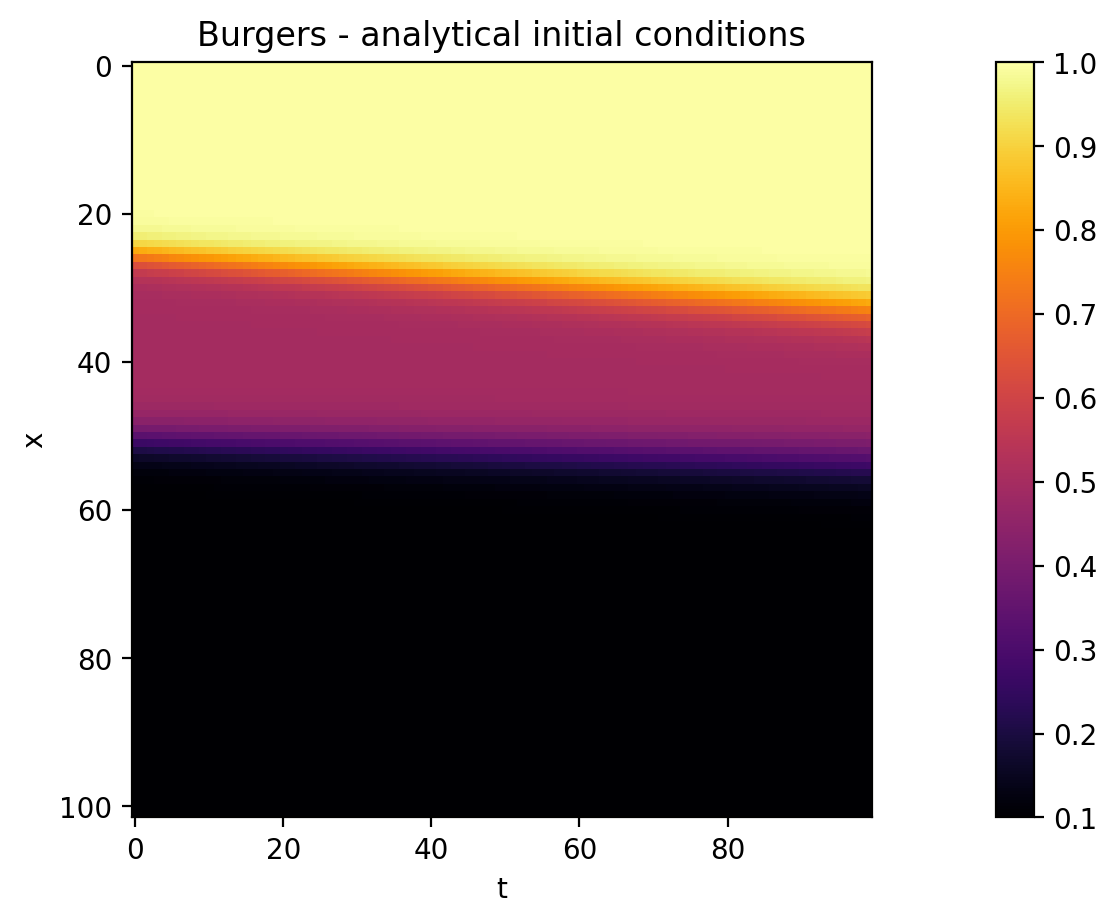

In [46]:
u0 = analytical_init(t, x, nu)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'Burgers - analytical initial conditions', 't', 'x')
# simple_plotter(u_df, 'u(t, x)')

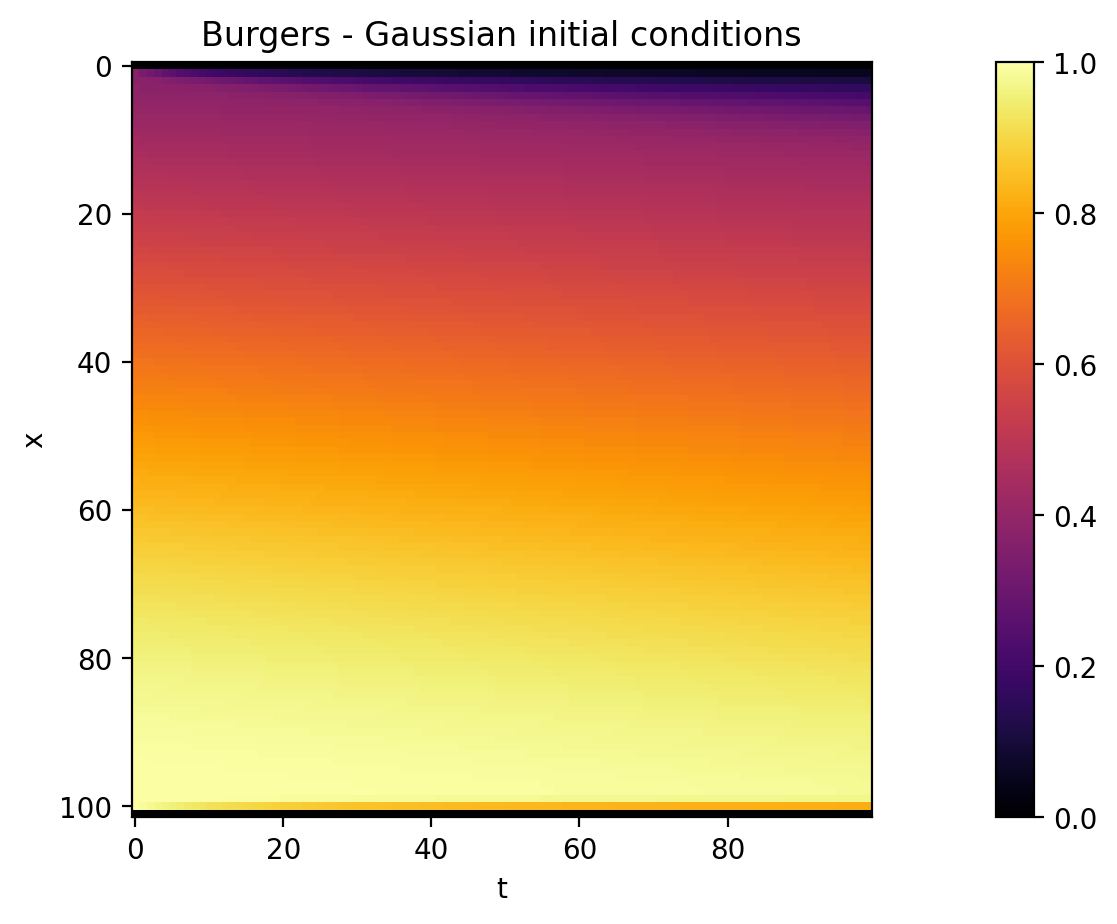

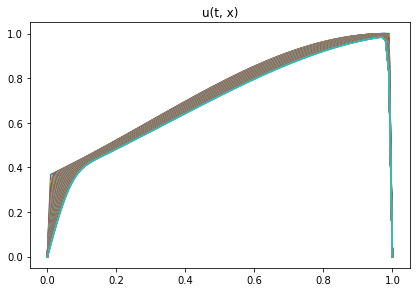

In [39]:
u0 = gaussian_init(t, x)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'Burgers - Gaussian initial conditions', 't', 'x')
simple_plotter(u_df, 'u(t, x)')

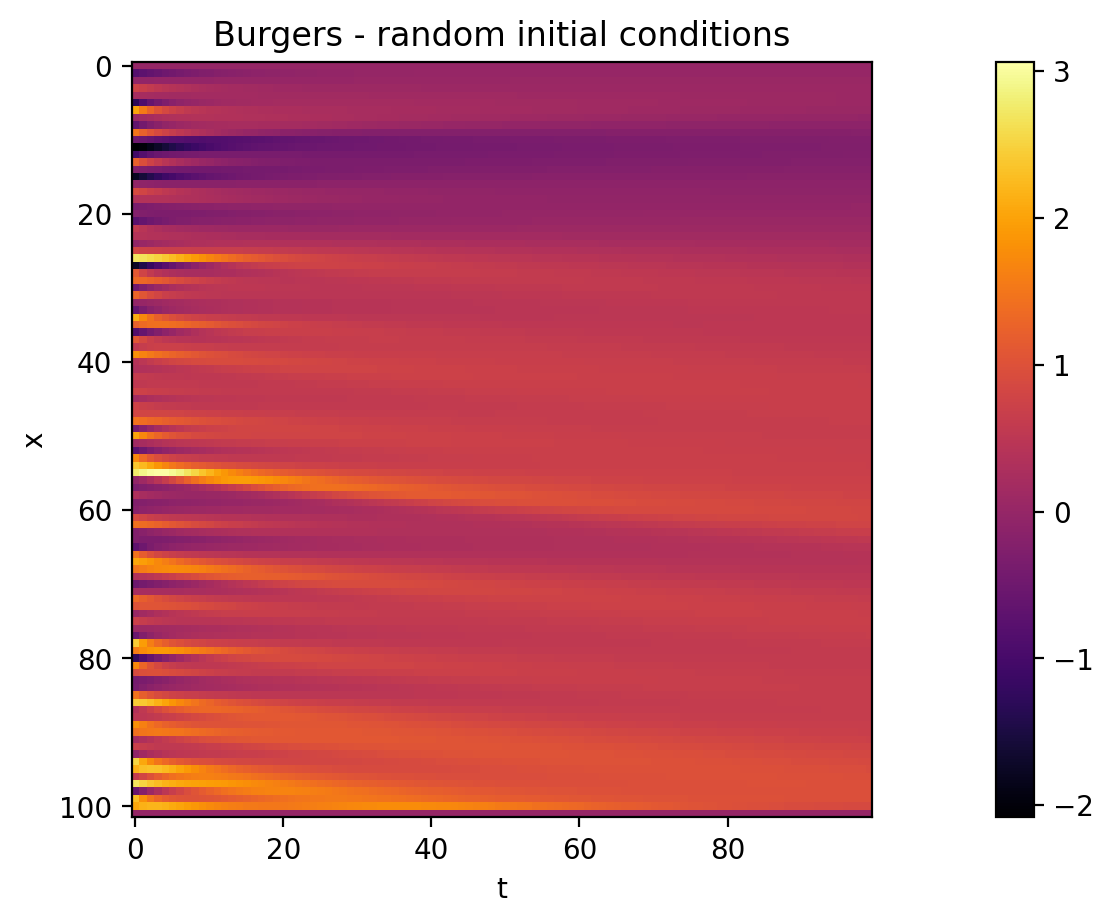

In [48]:
u0 = random_init(t, x)
u_df = get_burgers_fd(t_max, t_min, x_max, x_min, t_n, x_n, nu, u0)
show_state(u_df.T, 'Burgers - random initial conditions', 't', 'x')